In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

!pip install gdown
!gdown 'https://drive.google.com/uc?id=1x4ef5uIrz9CCpJk_-45cuIGLHk0iHrMT'


!unzip 'for_unzipping.zip'
!mv for_unzipping/* ./
!rm -r for_unzipping
!rm for_unzipping.zip

Downloading...
From: https://drive.google.com/uc?id=1x4ef5uIrz9CCpJk_-45cuIGLHk0iHrMT
To: /content/for_unzipping.zip
100% 719k/719k [00:00<00:00, 47.2MB/s]
Archive:  for_unzipping.zip
   creating: for_unzipping/frames/
   creating: for_unzipping/results/
   creating: for_unzipping/videos/
  inflating: for_unzipping/videos/traffic.gif  


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2

In [ ]:
source_folder = 'videos'
video = 'traffic.gif'

source_path = f'./{source_folder}/{video}'

In [ ]:
data_folder = 'frames'

frames_path = f"./{data_folder}/{video.rsplit('.', 1)[0]}"

In [ ]:
%%capture

!mkdir -p {frames_path} > /dev/null ;

In [ ]:
%%capture

!ffmpeg -i {source_path} {frames_path}/'frame_%04d.png' > /dev/null ;

In [ ]:
import glob

frames = []

for file_path in sorted(glob.glob(f'{frames_path}/*.png', recursive = False)):
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img = np.asarray(img, dtype=np.float64)
    img /= 255.0

    frames.append(img)

frames = np.asarray(frames, dtype=np.float64)

In [ ]:
from sklearn.model_selection import train_test_split

print(f'frame: {frames.shape}')

train_frames, test_frames = train_test_split(frames, train_size=0.6, shuffle=False) # Do Not Shuffle!

print(f'train_frames: {train_frames.shape}')
print(f'test_frames: {test_frames.shape}')

frame: (80, 120, 160, 3)
train_frames: (48, 120, 160, 3)
test_frames: (32, 120, 160, 3)


In [ ]:
import numpy as np

class GMM(object):

    def __init__(self, n_components=1, tol=1e-3, max_iter=100):
        """
        Initialize Gaussian Mixture Model parameters.

        Parameters:
        - n_components: The number of mixture components.
        - tol: The convergence threshold.
        - max_iter: Maximum number of iterations.
        """
        self.n_components = n_components
        self.tol = tol
        self.max_iter = max_iter
        self.weights = None
        self.means = None
        self.covars = None

    def initialize_params(self, X):
        """
        Initialize parameters: weights, means, and covariances.

        Parameters:
        - X: A collection of `N` training data points, each with dimension `d`.
        """
        N, d = X.shape
        # Initialize weights uniformly
        self.weights = np.ones(self.n_components) / self.n_components
        # Randomly initialize means
        self.means = X[np.random.choice(N, self.n_components, replace=False)]
        # Initialize covariances as identity matrices
        self.covars = np.tile(np.identity(d), (self.n_components, 1, 1))

    def _multivariate_gaussian_pdf(self, X, mean, covariance):
        """
        Calculate the multivariate Gaussian probability density function.

        Parameters:
        - X: Input data.
        - mean: Mean of the Gaussian distribution.
        - covariance: Covariance matrix of the Gaussian distribution.
        """
        d = X.shape[1]
        constant = 1 / ((2 * np.pi) ** (d / 2) * np.linalg.det(covariance) ** 0.5)
        exponent = -0.5 * np.sum(np.dot(X - mean, np.linalg.inv(covariance)) * (X - mean), axis=1)
        return constant * np.exp(exponent)

    def _e_step(self, X):
        """
        Expectation step: Calculate responsibilities.

        Parameters:
        - X: Input data.
        """
        responsibilities = np.zeros((len(X), self.n_components))
        for k in range(self.n_components):
            responsibilities[:, k] = self.weights[k] * self._multivariate_gaussian_pdf(X, self.means[k], self.covars[k])
        responsibilities /= np.sum(responsibilities, axis=1, keepdims=True)
        return responsibilities

    def _m_step(self, X, responsibilities):
        """
        Maximization step: Update parameters.

        Parameters:
        - X: Input data.
        - responsibilities: Responsibilities computed in the E-step.
        """
        N_k = np.sum(responsibilities, axis=0)
        self.weights = N_k / len(X)
        self.means = np.dot(responsibilities.T, X) / N_k[:, np.newaxis]
        for k in range(self.n_components):
            diff = X - self.means[k]
            covariance = np.dot(responsibilities[:, k] * diff.T, diff) / N_k[k]
            # Add a small multiple of the identity matrix for regularization
            covariance += 1e-6 * np.identity(X.shape[1])
            self.covars[k] = covariance


    def fit(self, X, y=None):
        """
        Fit the Gaussian Mixture Model to the input data.

        Parameters:
        - X: Input data.
        """
        self.initialize_params(X)
        prev_log_likelihood = None
        for iteration in range(self.max_iter):
            responsibilities = self._e_step(X)
            self._m_step(X, responsibilities)
            log_likelihood = np.sum(np.log(np.sum(responsibilities, axis=1)))
            if prev_log_likelihood is not None and abs(log_likelihood - prev_log_likelihood) < self.tol:
                break
            prev_log_likelihood = log_likelihood

    def predict(self, X):
        """
        Predict the labels for the input data.

        Parameters:
        - X: Input data.

        Returns:
        - Predicted labels.
        """
        responsibilities = self._e_step(X)
        return np.argmax(responsibilities, axis=1)


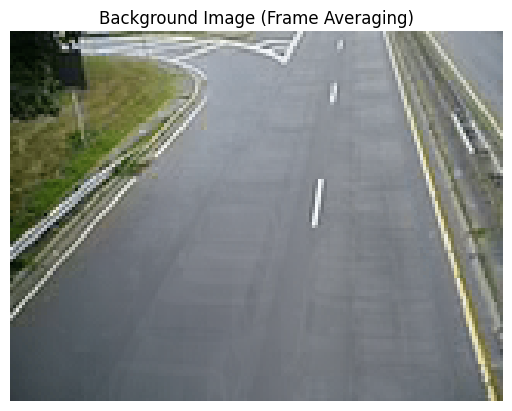

In [ ]:
import numpy as np

# Compute the average of all training frames
background_image_avg = np.mean(train_frames, axis=0)

# Display the background image
plt.imshow(background_image_avg)
plt.title("Background Image (Frame Averaging)")
plt.axis('off')
plt.show()

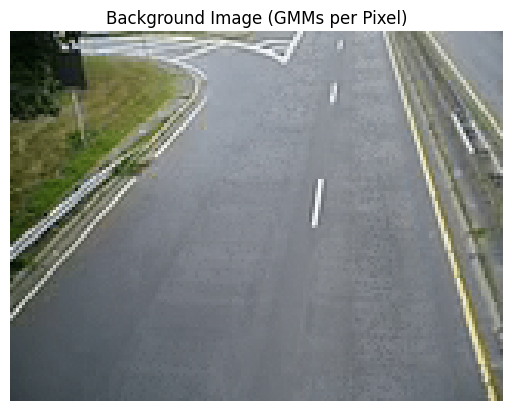

In [ ]:
# Reshape train_frames to have shape (num_samples, num_pixels, num_channels)
num_samples, height, width, channels = train_frames.shape
train_frames_reshaped = train_frames.reshape(num_samples, height*width, channels)

# Initialize GMMs for every pixel
gmm_models = []
for pixel_idx in range(height*width):
    gmm = GMM(n_components=2, tol=1e-3, max_iter=100)
    gmm_models.append(gmm)

# Fit GMMs for every pixel using training frames
for gmm, pixel_values in zip(gmm_models, train_frames_reshaped.transpose(1, 0, 2)):
    gmm.fit(pixel_values)

# Extract the mean background image from the trained GMMs
background_image_gmm = np.zeros((height, width, channels))
for pixel_idx, gmm in enumerate(gmm_models):
    responsibilities = gmm._e_step(train_frames_reshaped[:, pixel_idx, :])
    background_image_gmm[pixel_idx // width, pixel_idx % width] = gmm.means[np.argmax(gmm.weights)]

# Display the background image extracted using GMMs per pixel
plt.imshow(background_image_gmm)
plt.title("Background Image (GMMs per Pixel)")
plt.axis('off')
plt.show()


In [ ]:
# helper functions

def display_frames(frames, fps=10.0):
    """
    Display the frames as a video.
    """
    eps = 0.0001

    wait_time = int(1000 // fps)

    for frame in frames:
        frame = frame.astype(np.float64)
        frame = (frame - frame.min()) * 255 / (frame.max() - frame.min() + eps)
        frame = frame.astype(np.uint8)

        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

        # cv2.imshow("video", frame)
        k = cv2.waitKey(wait_time)

        if k == ord('q'):
            print("Quitting...")
            break

    cv2.destroyAllWindows()


def save_frames(frames, fps=10.0, output_path='./results', file_name='temp'):
    """
    Save the frames as a video.
    """
    eps = 0.0001

    frame_rate = float(fps)
    frame_size = (int(frames[0].shape[1]), int(frames[0].shape[0]))
    wait_time = int(1000 // fps)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')

    save_path = os.path.join(output_path, f"{file_name.rsplit('.', 1)[0]}.mp4")

    vid_wrt = cv2.VideoWriter(save_path, fourcc, frame_rate, frame_size)

    for frame in frames:
        frame = frame.astype(np.float64)
        frame = (frame - frame.min()) * 255 / (frame.max() - frame.min() + eps)
        frame = frame.astype(np.uint8)

        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

        # cv2.imshow('frame',frame)
        if cv2.waitKey(wait_time) & 0xFF == ord('q'):
            break

        vid_wrt.write(frame)


    vid_wrt.release()
    cv2.destroyAllWindows()

In [ ]:
## Frame Averaging

# Subtract the background image from each test frame to obtain the foreground
foreground_frames_avg = test_frames - background_image_avg

# Thresholding
# Define a threshold value
threshold_value = 0.1

# Threshold the difference image
foreground_frames_thresholded_avg = (foreground_frames_avg > threshold_value).astype(np.float64)

save_frames(foreground_frames_thresholded_avg, output_path='./results', file_name='foreground_frames_avg')

In [ ]:
## GMM Method

num_samples_test = test_frames.shape[0]
test_frames_reshaped = test_frames.reshape(num_samples_test, height*width, channels)

# Subtract the background image from each test frame using GMM
foreground_frames_gmm = np.zeros_like(test_frames)
for i in range(num_samples_test):
    for pixel_idx, gmm in enumerate(gmm_models):
        responsibilities = gmm._e_step(test_frames_reshaped[i, pixel_idx, :].reshape(1, -1))
        foreground_frames_gmm[i, pixel_idx // width, pixel_idx % width] = test_frames_reshaped[i, pixel_idx, :] - gmm.means[np.argmax(gmm.weights)]

#Thresholding
# Define a threshold value
threshold_value = 0.1

# Threshold the difference image
foreground_frames_thresholded_gmm = (foreground_frames_gmm > threshold_value).astype(np.float64)

# Display the foreground frames
save_frames(foreground_frames_thresholded_gmm, output_path='./results', file_name='foreground_frames_gmm')


<ipython-input-9-62c86cd48fe2>:60: RuntimeWarning: invalid value encountered in divide
  responsibilities /= np.sum(responsibilities, axis=1, keepdims=True)
